Analysis tools
==============

NetCDF4
-------

First, we need some imports to load our YANK output.

YANK writes NetCDF4 formatted files, which are platform-independent files that can store various matrix datasets with metadata in a self-documenting way.  It's kind of like XML for numeric data.  There's tons of support behind the NetCDF4 format and various implementations of readers and writers, with APIs in every popular language.

You can learn more about NetCDF here: http://www.unidata.ucar.edu/software/netcdf/
        
We make use of the netcdf4-python release: https://code.google.com/p/netcdf4-python/
        
NetCDF4 libraries and interfaces are supplied standard with many scientific Python distributions, such as Enthought Canopy [https://www.enthought.com/products/canopy/] and continuum.io Anaconda [https://store.continuum.io/cshop/anaconda/].

In [1]:
import netCDF4 as netcdf
import numpy

MBAR
----

We use the asymptotically-optimal multistate Bennett acceptance ratio (MBAR) to estimate free energies from our data, since it squeezes all of the available information from the data in an optimal way.  More about MBAR can be found in the MBAR paper and various associated publications comparing the performance of MBAR to TI, etc:
    
http://dx.doi.org/10.1063/1.2978177
    
We'll also need the Python implementation of the MBAR package [http://github.com/choderalab/pymbar], which also provides a module for dealing with correlated timeseries data.

In [2]:
import pymbar
from pymbar import timeseries

analyze
-------

We'll also make use of a special analysis module with some helper functions for dealing with files that YANK produces.

In [3]:
import analyze

pylab
-----

We'll also make use of pylab to make pretty plots.

In [4]:
%matplotlib inline
import pylab

/Users/choderaj/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Datafile access
===============

We'll open the NetCDF datafile for a simulation of p-xylene and T4 lysozyme L99A.

In [5]:
filename = 'p-xylene/complex.nc'
ncfile = netcdf.Dataset(filename, 'r')

The NetCDF file can be easily queried for the various dimensions of the dataset.

In [6]:
niterations = ncfile.variables['positions'].shape[0]                                                                                                                                                                                              
nstates = ncfile.variables['positions'].shape[1]                                                                                                                                                                                                  
natoms = ncfile.variables['positions'].shape[2]                                                                                                                                                                                                   
print "Read %(niterations)d iterations, %(nstates)d states, %(natoms)d atoms" % vars() 

Read 1856 iterations, 24 states, 2621 atoms


Equilibration
=============

Is equilibration necessary?
---------------------------

In principle, we don't need to discard initial "unequilibrated" data; the estimate over a very long trajectory will converge to the correct free energy estimate no matter what---we simply need to run long enough.  Some MCMC practitioners, like Geyer, feel strongly enough about this to throw up a webpage in defense of this position:

http://users.stat.umn.edu/~geyer/mcmc/burn.html

In practice, if the initial conditions are very atypical of equilibrium (which is often the case in molecular simulation), it helps a great deal to discard an initial part of the simulation to equilibration.  But how much?  How do we decide?

Determining equilibration in a replica-exchange simulation
----------------------------------------------------------

For a standard molecular dynamics simulation producing a trajectory $x_t$, it's reasonably straightforward to decide approximately how much to discard if human intervention is allowed.  We simply look at some property $A_t = A(x_t)$ over the course of the simulation---ideally, a property that we know has some slow behavior that may affect the quantites we are intersted in computing ($A(x)$ is a good choice if we're interested in the expectation $<A>$) and find the point where $A_t$ seems to have "settled in" to typical equilibrium behavior.

If we're interested in a free energy, which is computed from the potential energy differences, let's suppose the potential energy $U(x)$ may be a good quantity to examine.

But in a replica-exchange simulation, there are K replicas that execute nonphysical walks on many potential energy functions $U_k(x)$.  What quantity do we look at here?

Let's work by analogy.  In a single simulation, we would plot some quantity related to the potential energy $U(x)$, or its reduced version $u(x) = \beta U(x)$.  This is actually the negative logarithm of the probability density $\pi(x)$ sampled, up to an additive constant:

$$\pi(x) = Z^{-1} e^{-u(x)}$$
$$u(x) = -\ln \pi(x) + c$$

For a replica-exchange simulation, the sampler state is given by the pair $(X,S)$, where $X = \{x_1, x_2, \ldots, x_K \}$ are the replica configurations and $S = \{s_1, s_2, \ldots, s_K\}$ is the vector of state index permutations associated with the replicas.  The total probability sampled is

$$\Pi(X,S) = \prod_{k=1}^K \pi_{s_k}(x_k) = (Z_1 \cdots Z_K) \exp\left[-\sum_{k=1}^K u_{s_k}(x_k)\right] = Q^{-1} e^{-u_*(X)}$$

where the pseudoenergy $u_*(X)$ for the replica-exchange simulation is defined as

$$u_*(X) \equiv \sum_{k=1}^K u_{s_k}(x_k)$$

That is, $u_*(X)$ is the sum of the reduced potential energies of each replica configuration at the current thermodynamic state it is vsiting.

Let's look at the timeseries for this quantity:

Reading energies...
Done.
Deconvoluting replicas...
Done.


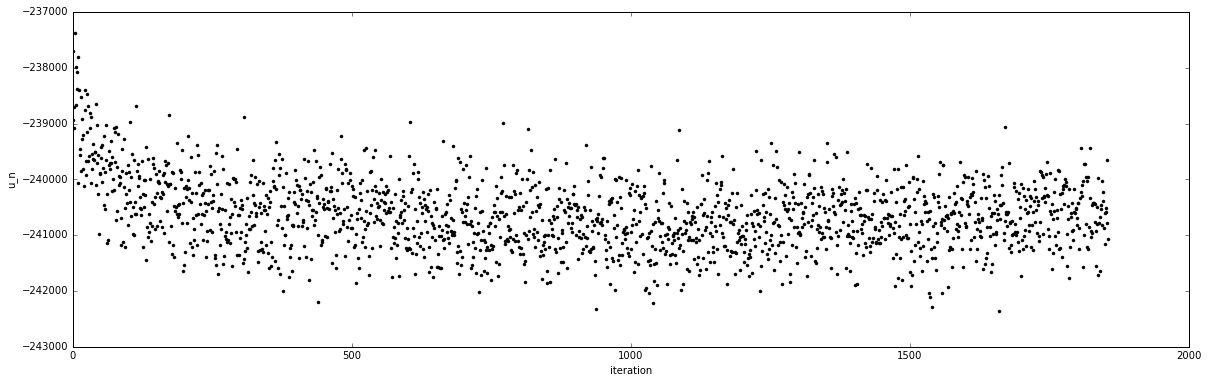

In [7]:
u_n = analyze.extract_u_n(ncfile)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 6

pylab.clf()
pylab.plot(u_n, 'k.')
pylab.xlabel('iteration')
pylab.ylabel('u_n')
pylab.show()

Automatic equilibration detection
---------------------------------

It's clear that this timeseries has an initial transient that is uncharacteristic of the remainder of the trajectory.  We could guess this may be approximately the first 200 iterations, by eye.  But what would we do if we can't look at every trace?  Is there a simple algorithm we can use to figure out how much we should discard?

What if we pick some arbitrary time $t_0$ and discard all $t \in [0, t_0)$ to equilibration, keeping $[t_0, T]$ as the dataset to analyze.  How much data remains?
                                                                  
We can determine this by computing the statistical inefficiency $g$ for the interval $[t_0, T]$ and computing the effective number of uncorrelated samples $N_{eff} = (T-t_0)/g$.

If we start at $t_0 \approx T$ and move $t_0$ earlier and earlier, we expect that the effective number of uncorrelated samples will grow until we start to include highly atypical data.  At that point, the correlation time will greatly increase, and the effective number of uncorrelated samples will plummet.  Let's compute this for our dataset.

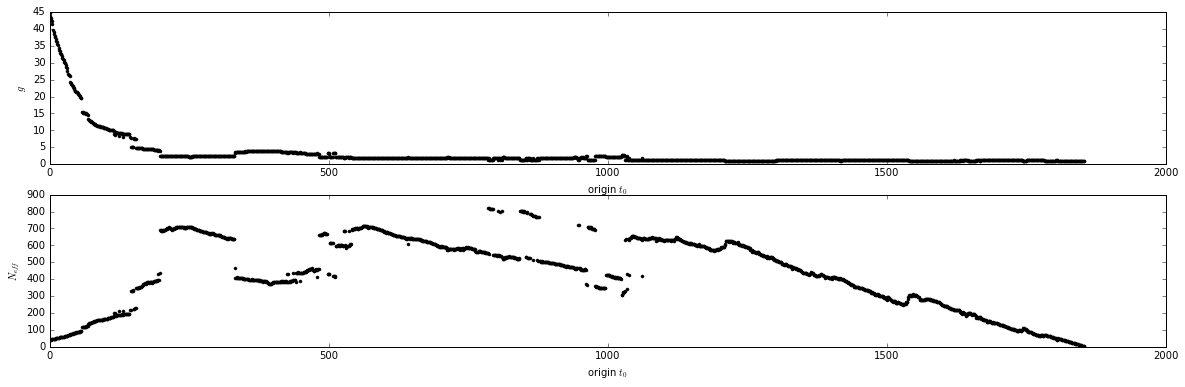

In [8]:
T = len(u_n)
T = min(T, 2500) # just analyze beginning of simulation if it's really long
g_t = numpy.ones([T-1], numpy.float32)
Neff_t = numpy.ones([T-1], numpy.float32)
for t in range(T-1):
    g_t[t] = timeseries.statisticalInefficiency(u_n[t:T])
    Neff_t[t] = (T-t+1) / g_t[t]

pylab.clf()
pylab.subplot(211)
pylab.plot(g_t, 'k.')
pylab.ylabel('$g$')
pylab.xlabel('origin $t_0$')
pylab.subplot(212)
pylab.plot(Neff_t, 'k.')
pylab.xlabel('origin $t_0$')
pylab.ylabel('$N_{eff}$')
pylab.show()

We don't have to evaluate every time origin $t0$, of course.  We can simply evaluate $t_0$ periodically within the sample.

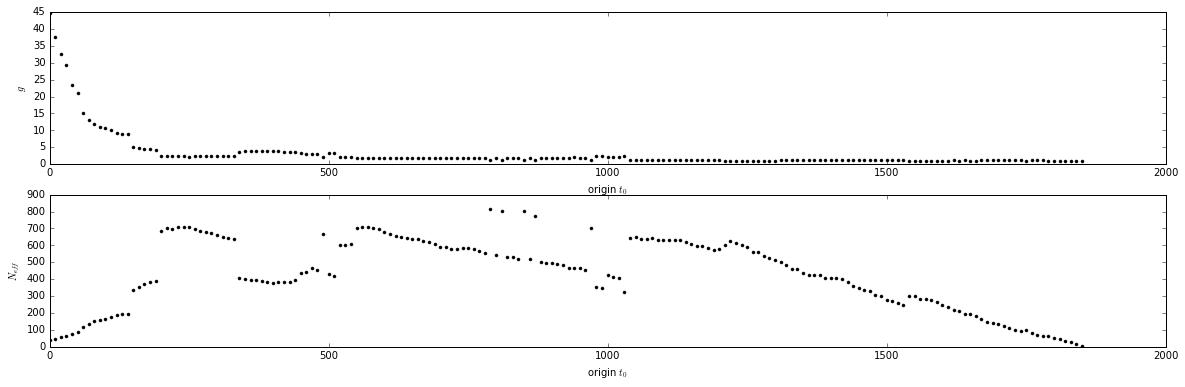

In [9]:
T = len(u_n)
nskip = 10
indices = range(0, T-1, nskip)
N = len(indices)
t0_t = numpy.ones([N], numpy.float32)
g_t = numpy.ones([N], numpy.float32)
Neff_t = numpy.ones([N], numpy.float32)
for n in range(N):
    t0 = nskip*n
    t0_t[n] = t0
    g_t[n] = timeseries.statisticalInefficiency(u_n[t0:T])
    Neff_t[n] = (T-t0) / g_t[n]

pylab.clf()
pylab.subplot(211)
pylab.plot(t0_t, g_t, 'k.')
pylab.ylabel('$g$')
pylab.xlabel('origin $t_0$')
pylab.subplot(212)
pylab.plot(t0_t, Neff_t, 'k.')
pylab.xlabel('origin $t_0$')
pylab.ylabel('$N_{eff}$')
pylab.show()

Wow!  It's really easy to see where the statistical inefficiency starts to jump up due to the inclusion of unequilibrated data, and there's an unambiguous choice of $t_0$ that maximizes the effective number of uncorrelated sanmples $N_{eff}$.  Let's use use this as a heuristic to select $t_0$.

In [10]:
[nequil, g, Neff_max] = timeseries.detectEquilibration(u_n, nskip=10)
print "The first %d samples should be discarded to equilibration, leaving %.1f effectively uncorrelated samples in the remainder (statistical inefficiency g = %.1f)." % (nequil, Neff_max, g)

The first 560 samples should be discarded to equilibration, leaving 902.6 effectively uncorrelated samples in the remainder (statistical inefficiency g = 1.4).


Mixing statistics
=================

We can analyze the "mixing statistics" of the equilibrated part of the simulation to ensure that the $(X,S)$ chain is mixing reasonably well among the various alchemical states.

In practice, this is done by recording the number of times a replica transitions from alchemical state $i$ to state $j$ in a single iteration.  Because the overall chain must obey detailed balance, we count each transition as contributing 0.5 counts toward the $i \rightarrow j$ direction and 0.5 toward the $j \rightarrow i$ direction.  This has the advantage of ensuring that the eigenvalues of the resulting transition matrix among alchemical states are purely real.

In [11]:
analyze.show_mixing_statistics(ncfile, cutoff=0.05, nequil=nequil)

Cumulative symmetrized state mixing transition matrix:
            0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23 
0       0.466  0.299  0.089                                                                                                                                                    
1       0.299  0.383  0.154  0.054                                                                                                                                             
2       0.089  0.154  0.314  0.225  0.125  0.058                                                                                                                               
3              0.054  0.225  0.375  0.192  0.073                                                                                                                               
4                     0.125  0.192  0.246  0.181  0.086          

Note that if the subdominant eigenvalue would have been unity, then the chain would be *decomposable*, meaning that it completely separated into two separate sets of alchemical states that did not mix.  This would have been an indication of poor phase space overlap between some alchemical states.

In practice, it's a great idea to monitor these statistics as the simulation is running, even if no data is discarded to equilibration at that point.  They give not only a good idea of whether sufficient mixing is occuring, but it provides a lower bound on the mixing time in configuration space.

If the configuration $x$ sampling is infinitely fast so that $x$ can be considered to be at equilibrium given the instantaneous permutation $S$ of alchemical state assignments, the subdominant eigenvalue $\lambda_2 \in [0,1]$ gives an estimate of the mixing time of the overall $(X,S)$ chain:
    
$$\tau = \frac{1}{1 - \lambda_2}$$

Now, in most cases, the configuration $x$ sampling is *not* infinitely fast, but at least we can use $\tau$ to get a very crude estimate of how quickly each replica relaxes in $(X,S)$ space.



Gelman-Rubin convergence diagnostics
====================================

In 1992, Gelman and Rubin proposed a very clever idea for a convergence diagnostic in the case that multiple MCMC samplers are run from different initial sampler states:

http://dx.doi.org/10.1214/ss/1177011136

The idea is simple: Each chain gives an individual estimate for some computed expectation or property, and the whole collection of chains give a (presumably more precise) estimate.  We can simply compare the individual estimates to the overall estimate to determine whether the chains have been run long enough to see concordance between the individual and global estimates, to within appropriate statistical error.  If not, then the samplers have not yet run long enough to sample all of the important modes of the density.
    
We can apply a similar idea here, especially if we have initialized our replicas with different configurations (e.g. different docked ligand conformations, and potentially different protein conformations as well).

Let's first compute the global estimate of the free energy differences between thermodynamic states using all replicas:

In [12]:
(Deltaf_ij, dDeltaf_ij) = analyze.estimate_free_energies(ncfile, ndiscard=nequil, g=g)

In [13]:
print "Free energy difference (estimated using all replicas): %8.3f +- %8.3f kT" % (Deltaf_ij[0,-1], dDeltaf_ij[0,-1])

Free energy difference (estimated using all replicas):   14.224 +-    0.065 kT


In [14]:
replica_estimates = list()
for replica in range(nstates):
    (Deltaf_ij_replica, dDeltaf_ij_replica) = analyze.estimate_free_energies(ncfile, ndiscard=nequil, g=g, replicas=[replica])
    replica_estimates.append( (Deltaf_ij_replica, dDeltaf_ij_replica) )
    print "Free energy difference (estimated using replica %5d): %8.3f +- %8.3f kT" % (replica, Deltaf_ij_replica[0,-1], dDeltaf_ij_replica[0,-1])

Free energy difference (estimated using replica     0):   12.039 +-    0.262 kT
Free energy difference (estimated using replica     1):   15.896 +-    0.320 kT
Free energy difference (estimated using replica     2):   13.972 +-    0.388 kT
Free energy difference (estimated using replica     3):   15.201 +-    0.271 kT
Free energy difference (estimated using replica     4):   15.093 +-    0.298 kT
Free energy difference (estimated using replica     5):   12.111 +-    0.473 kT
Free energy difference (estimated using replica     6):   14.692 +-    0.330 kT
Free energy difference (estimated using replica     7):   18.999 +-    1.258 kT
Free energy difference (estimated using replica     8):   12.128 +-    0.508 kT
Free energy difference (estimated using replica     9):   32.212 +-    0.779 kT
Free energy difference (estimated using replica    10):   15.081 +-    0.274 kT
Free energy difference (estimated using replica    11):   13.245 +-    0.353 kT
Free energy difference (estimated using 

Let's compare the individual replica estimates of the free energy difference to the global estimate from pooling all replicas.

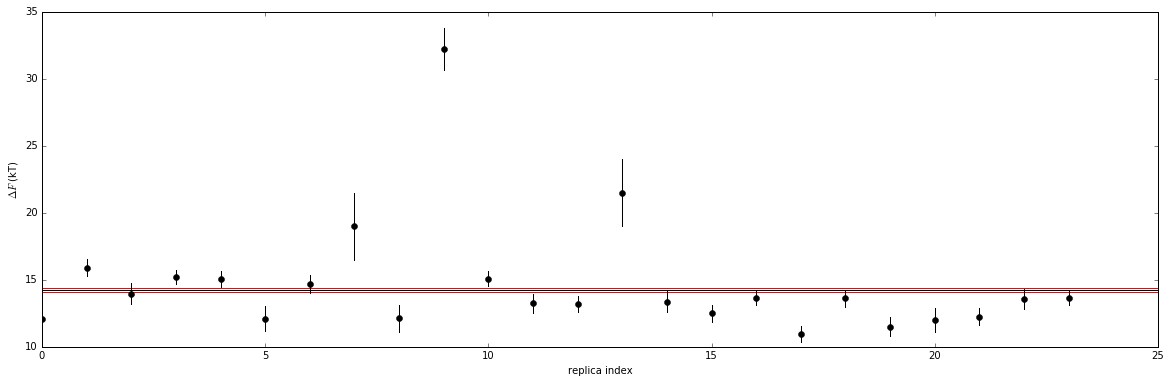

In [15]:
pylab.clf()
pylab.hold(True)
# State indices for free energy difference.
(i,j) = (0,nstates-1)
nreplicas = nstates
# Plot global estimate and confidence bands.
DeltaF = Deltaf_ij[i,j]
dDeltaF = dDeltaf_ij[i,j]
pylab.plot([0, nreplicas+1], [DeltaF, DeltaF], 'k-')
pylab.plot([0, nreplicas+1], [DeltaF+2*dDeltaF, DeltaF+2*dDeltaF], 'r-')
pylab.plot([0, nreplicas+1], [DeltaF-2*dDeltaF, DeltaF-2*dDeltaF], 'r-')
# Plot replica estimates.
for replica in range(nreplicas):
    (Deltaf_ij_replica, dDeltaf_ij_replica) = replica_estimates[replica]
    DeltaF = Deltaf_ij_replica[i,j]
    dDeltaF = dDeltaf_ij_replica[i,j]
    pylab.plot([replica], [DeltaF], 'ko')
    pylab.plot([replica,replica], [DeltaF+2*dDeltaF,DeltaF-2*dDeltaF], 'k-')
pylab.xlabel('replica index')
pylab.ylabel('$\Delta F$ (kT)')
pylab.show()

The global and replica estimates are shown with two standard errors (approximate 95% confidence intervals).  If the simulation has converged, each nearly independent replica estimate should have a 5% of the replicas should be outside this interval.

We can turn these deviations into Z-scores:

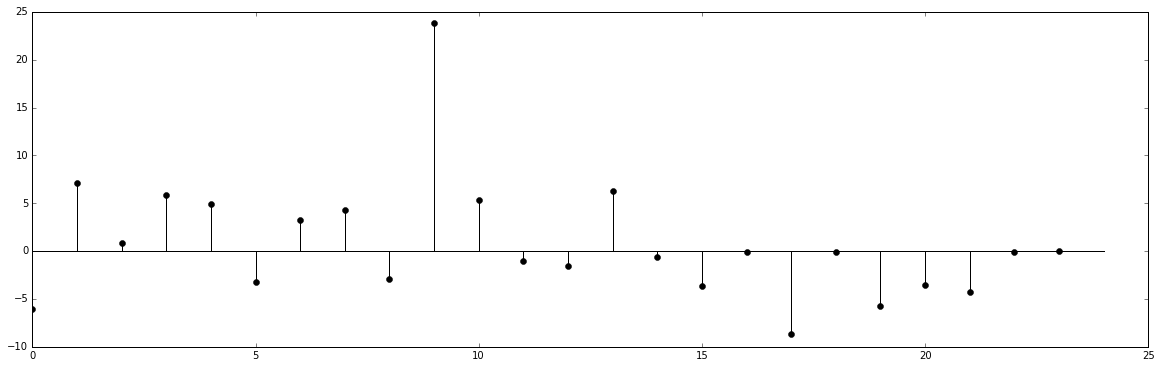

In [16]:
Zscores = numpy.zeros([nreplicas], numpy.float64)
DeltaF_global = Deltaf_ij_replica[i,j]
for replica in range(nreplicas):
    (Deltaf_ij_replica, dDeltaf_ij_replica) = replica_estimates[replica]
    DeltaF_replica = Deltaf_ij_replica[i,j]
    dDeltaF_replica = dDeltaf_ij_replica[i,j]        
    Zscores[replica] = (DeltaF_replica - DeltaF_global) / dDeltaF_replica

pylab.clf()
pylab.hold(True)
pylab.plot([0, nreplicas], [0, 0], 'k-')
pylab.plot(Zscores, 'ko')
for replica in range(nreplicas):
    pylab.plot([replica, replica], [0, Zscores[replica]], 'k-')
pylab.show()

We can also examine the dynamics of how this evolves by looking at how the replica estimates changed from when only 1/4 of the data was used.

Free energy difference (estimated using replica     0):   14.318 +-    0.428 kT
Free energy difference (estimated using replica     1):   13.407 +-    0.657 kT
Free energy difference (estimated using replica     2):   11.761 +-    0.520 kT
Free energy difference (estimated using replica     3):   12.679 +-    0.553 kT
Free energy difference (estimated using replica     4):   13.849 +-    0.888 kT
Free energy difference (estimated using replica     5):   10.902 +-    0.564 kT
Free energy difference (estimated using replica     6):   11.078 +-    0.598 kT
Free energy difference (estimated using replica     7):   19.389 +-    0.958 kT
Free energy difference (estimated using replica     8):   11.320 +-    0.834 kT
Free energy difference (estimated using replica     9):   31.022 +-    0.955 kT
Free energy difference (estimated using replica    10):   15.216 +-    0.581 kT
Free energy difference (estimated using replica    11):   22.620 +-    0.837 kT
Free energy difference (estimated using 

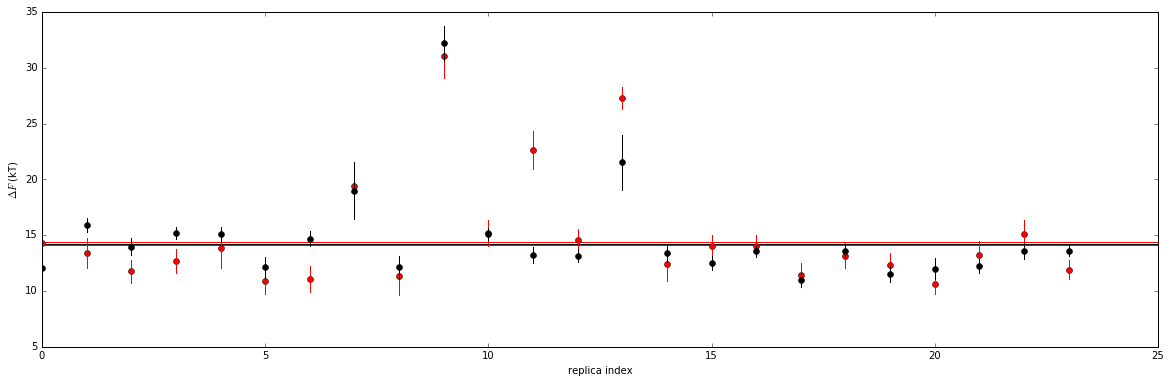

In [17]:
earlier_replica_estimates = list()
nuse = int((niterations - nequil)/4.0)
for replica in range(nstates):
    (Deltaf_ij_replica, dDeltaf_ij_replica) = analyze.estimate_free_energies(ncfile, ndiscard=nequil, g=g, replicas=[replica], nuse=nuse)
    earlier_replica_estimates.append( (Deltaf_ij_replica, dDeltaf_ij_replica) )
    print "Free energy difference (estimated using replica %5d): %8.3f +- %8.3f kT" % (replica, Deltaf_ij_replica[0,-1], dDeltaf_ij_replica[0,-1])
pylab.clf()
pylab.hold(True)
# State indices for free energy difference.
(i,j) = (0,nstates-1)
nreplicas = nstates
# Plot global estimate and confidence bands.
DeltaF = Deltaf_ij[i,j]
dDeltaF = dDeltaf_ij[i,j]
pylab.plot([0, nreplicas+1], [DeltaF, DeltaF], 'k-')
pylab.plot([0, nreplicas+1], [DeltaF+2*dDeltaF, DeltaF+2*dDeltaF], 'r-')
pylab.plot([0, nreplicas+1], [DeltaF-2*dDeltaF, DeltaF-2*dDeltaF], 'r-')
# Plot replica estimates.
for replica in range(nreplicas):
    (Deltaf_ij_replica, dDeltaf_ij_replica) = earlier_replica_estimates[replica]
    DeltaF = Deltaf_ij_replica[i,j]
    dDeltaF = dDeltaf_ij_replica[i,j]
    pylab.plot([replica], [DeltaF], 'ro')
    pylab.plot([replica,replica], [DeltaF+2*dDeltaF,DeltaF-2*dDeltaF], 'r-')

    (Deltaf_ij_replica, dDeltaf_ij_replica) = replica_estimates[replica]
    DeltaF = Deltaf_ij_replica[i,j]
    dDeltaF = dDeltaf_ij_replica[i,j]
    pylab.plot([replica], [DeltaF], 'ko')
    pylab.plot([replica,replica], [DeltaF+2*dDeltaF,DeltaF-2*dDeltaF], 'k-')
pylab.xlabel('replica index')
pylab.ylabel('$\Delta F$ (kT)')
pylab.show()

In [18]:
Zscore = 0.0
DeltaF_global = Deltaf_ij_replica[i,j]
for replica in range(nreplicas):
    (Deltaf_ij_replica, dDeltaf_ij_replica) = earlier_replica_estimates[replica]
    DeltaF_replica = Deltaf_ij_replica[i,j]
    dDeltaF_replica = dDeltaf_ij_replica[i,j]
    Zscore += ((DeltaF_replica - DeltaF_global) / dDeltaF_replica)**2
print numpy.sqrt(Zscore / (nreplicas-1))

7.9248100568


Further thoughts
================

We can visually check that each replica undergoes a pseudorandom walk on the whole thermodynamic state space.

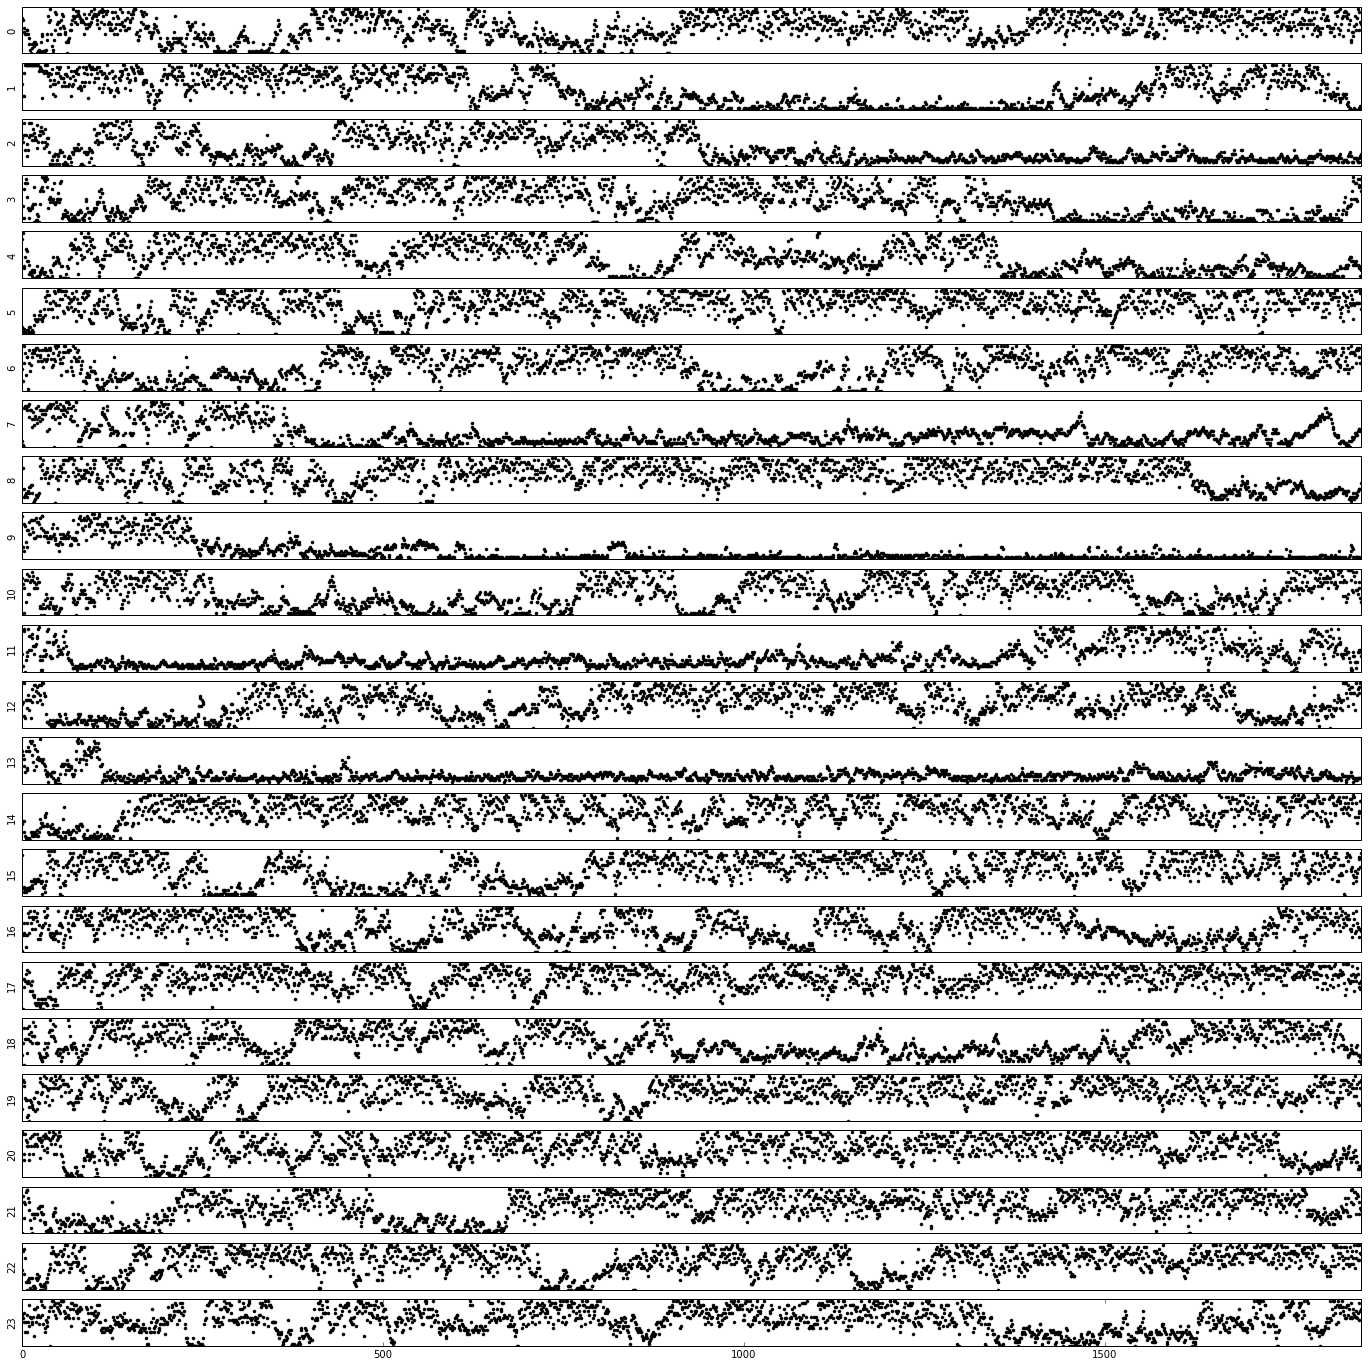

In [19]:
state_nk = ncfile.variables['states'][:,:]

pylab.figure(figsize=(24,24))
pylab.clf()
pylab.hold(True)
for k in range(nstates):
    pylab.subplot(nstates,1,k+1)
    pylab.plot(state_nk[:,k], 'k.')
    pylab.axis([0, niterations, 0, nstates])
    pylab.yticks([])
    if k < (nstates-1): pylab.xticks([])
    pylab.ylabel('%d' % k)
pylab.show()

We can also see that Val11 has some conformational transitions in the N-CA-CB-CG1 torsion angle thanks to the replica-exchange simulation, but slow transitions in this torsion will clearly cause us problems.

In [20]:
phi_kt = analyze.compute_torsion_trajectories(ncfile)

analyze.py:279: RuntimeWarning: invalid value encountered in arccos
  theta = numpy.arccos(cos_theta) * 180.0 / math.pi


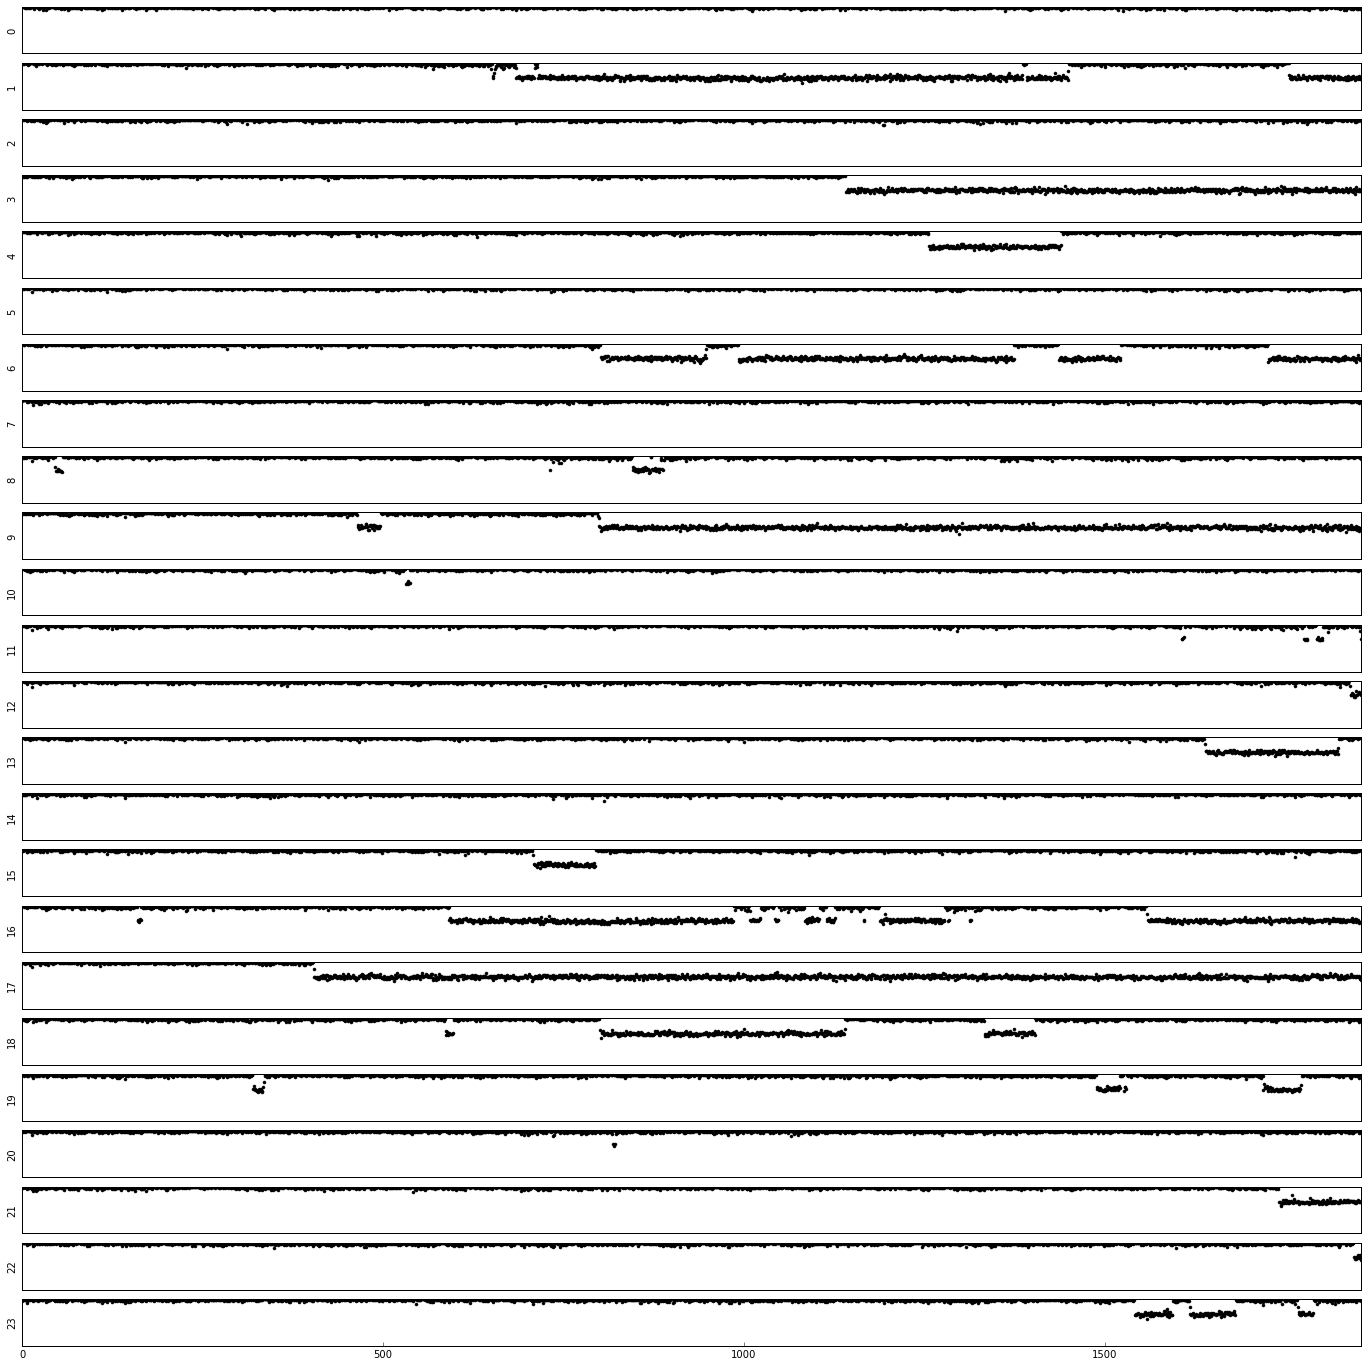

In [21]:
pylab.figure(figsize=(24,24))
pylab.clf()
pylab.hold(True)
for k in range(nstates):
    pylab.subplot(nstates,1,k+1)
    pylab.plot(phi_kt[k,:], 'k.')
    pylab.yticks([])
    pylab.ylabel('%d' % k)
    if k < (nstates-1): pylab.xticks([])
    pylab.axis([0, niterations, -180, +180])
pylab.show()